In [1]:
import pyedflib
import mne
import numpy as np
from scipy import ndimage
from scipy.io import savemat, loadmat
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import torch
from matplotlib.colors import ListedColormap
import pandas as pd
import logging
import os

# Constants
# PREPROCESSED_FILE_NAME = 'preprocessed_data_201_N1.mat'
# EDF_PATH = '../data/201 N1.edf'
# SLEEP_STAGES_PATH = '../data/SASE Sleep Stages 201_N1.xlsx'

# PREPROCESSED_FILE_NAME = 'preprocessed_data_201_N2.mat'
# EDF_PATH = '../data/201 N2.edf'
# SLEEP_STAGES_PATH = '../data/SASE Sleep Stages 201_N2.xlsx'

PREPROCESSED_FILE_NAME = 'preprocessed_data_202_N1.mat'
EDF_PATH = '../data/202 N1.edf'
SLEEP_STAGES_PATH = '../data/SASE Sleep Stages 202_N1.xlsx'

# PREPROCESSED_FILE_NAME = 'preprocessed_data_202_N2.mat'
# EDF_PATH = '../data/202 N2.edf'
# SLEEP_STAGES_PATH = '../data/SASE Sleep Stages 202_N2.xlsx'

# Configuration
BANDPASS_FILTER = (0.5, 50)
DOWNSAMPLE_FREQ = 100
BIPOLAR_CHANNELS = {
    'anode': ['F3-M2', 'C3-M2', 'F4-M1', 'C4-M1'],
    'cathode': ['C3-M2', 'O1-M2', 'C4-M1', 'O2-M1'],
    'names': ['F3-C3', 'C3-O1', 'F4-C4', 'C4-O2']
}
EPOCH_DURATION = 30
ARTIFACT_THRESHOLD = 500
FLAT_THRESHOLD = 1e-6
FLAT_DURATION = 5

# Target values for scaling
IQR_TARGET = torch.tensor([7.90, 11.37, 7.92, 11.56])
MED_TARGET = torch.tensor([0.0257, 0.0942, 0.02157, 0.1055])

def load_edf_file(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw._data *= 1e6  # Convert from volts to microvolts
    return raw

def preprocess_eeg(raw):
    raw.filter(*BANDPASS_FILTER, fir_design='firwin')
    raw.resample(DOWNSAMPLE_FREQ)
    
    bipolar_montage = mne.set_bipolar_reference(
        raw,
        anode=BIPOLAR_CHANNELS['anode'],
        cathode=BIPOLAR_CHANNELS['cathode'],
        ch_name=BIPOLAR_CHANNELS['names']
    )
    
    raw = bipolar_montage.pick_channels(BIPOLAR_CHANNELS['names'])
    return raw

def create_epochs(raw):
    return mne.make_fixed_length_epochs(raw, duration=EPOCH_DURATION, preload=True)

def detect_artifacts(data, threshold=ARTIFACT_THRESHOLD, flat_threshold=FLAT_THRESHOLD, flat_duration=FLAT_DURATION, sfreq=DOWNSAMPLE_FREQ):
    amplitude_mask = np.abs(data) > threshold
    
    diff = np.abs(np.diff(data))
    flat_mask = np.zeros_like(data, dtype=bool)
    flat_mask[:-1] = ndimage.uniform_filter1d(diff < flat_threshold, size=int(flat_duration * sfreq)) > 0.99
    
    return amplitude_mask, flat_mask

def handle_artifacts(data, artifact_mask):
    data[artifact_mask] = 0
    return data


def preprocess_sleep_stages(file_path, epochs_to_remove, keep_unscored=False):
    stage_mapping = {7: 4, 5: 3, 1: 2, 2: 1, 3: 0, 0: -1}
    
    # Check if the file is an Excel file
    if file_path.endswith('.xlsx'):
        # Load the Excel file, skipping the first two rows, and drop blank rows
        df = pd.read_excel(file_path, skiprows=1)
       
        sleep_stages = df.iloc[:, 0].values  # Assuming sleep stages are in the first column
    else:
        # Load and process text file, skipping first two lines and stripping blank rows
        with open(file_path, 'r') as file:
            lines = [line.strip() for line in file.readlines()[2:] if line.strip()]  # Skip the first two lines and remove blanks
        sleep_stages = np.array([int(line.split()[0]) for line in lines])

    # Find start and end indices of stage 7
    start_index = np.argmax(sleep_stages == 7)
    end_index = len(sleep_stages) - np.argmax(sleep_stages[::-1] == 7)

    # Expand the range by 50 epochs before start and after end
    sleep_stages[max(0, start_index - 50):start_index] = 7
    sleep_stages[end_index:min(len(sleep_stages), end_index + 50)] = 7

    # Process stages based on 'keep_unscored' flag
    processed_stages = sleep_stages if keep_unscored else sleep_stages[start_index:end_index]

    # Map stages using the stage_mapping dictionary
    renumbered_stages = np.vectorize(stage_mapping.get)(processed_stages)

    # Remove specified epochs
    np_stages = np.delete(renumbered_stages, list(epochs_to_remove), axis=0)

    return np_stages.reshape(1, -1)

def scale_channel_data(data, iqr_target, med_target):
    median = np.median(data)
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    return (data - median) / iqr * iqr_target + med_target

# Plotting functions
def plot_channel(data, artifact_mask, channel_name, fs):
    time = np.arange(len(data)) / fs
    plt.figure(figsize=(15, 5))
    plt.plot(time, data, label="Signal", color='blue')
    artifact_indices = np.where(artifact_mask)[0]
    if artifact_indices.size > 0:
        plt.scatter(time[artifact_indices], data[artifact_indices], color='red', label="Artifact", marker='.', s=10)
    edf_file_name = os.path.basename(EDF_PATH) 
    plt.title(f'{channel_name} from {edf_file_name}.edf (Preprocessed with Artifacts Highlighted)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (μV)')
    plt.legend()
    plt.show()

def plot_histogram(data, title='Histogram of EEG Amplitudes After Preprocessing', xlabel='Amplitude (μV)', ylabel='Frequency', bins=100, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    plt.hist(data.flatten(), bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_artifact_counts(ax, title, counts, color, xlabel, ylabel, epoch_label, log_scale=True):
    ax.bar(np.arange(len(counts)), counts, color=color, alpha=0.7)
    ax.set_title(f'{title} (Total: {int(np.sum(counts))})')
    ax.set_xlabel(f'{epoch_label} Epoch Index')
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, max(1, len(counts)))
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    if log_scale:
        ax.set_yscale('symlog')

def select_ticks(epoch_numbers, max_ticks=10):
    if len(epoch_numbers) <= max_ticks:
        return epoch_numbers
    step = max(1, len(epoch_numbers) // max_ticks)
    return epoch_numbers[::step]

def plot_combined_artifacts(ax, amp_counts, flat_counts, epoch_numbers, xlabel, ylabel):
    ax.bar(epoch_numbers, amp_counts, color='blue', alpha=0.7, label='Amplitude')
    ax.bar(epoch_numbers, flat_counts, color='red', alpha=0.7, label='Flat Signal')
    
    num_removed_epochs = len(epoch_numbers)
    ax.set_title(f'Artifacts in Removed Epochs (Total Removed: {num_removed_epochs})')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yscale('symlog')
    ax.legend()
    
    selected_ticks = select_ticks(epoch_numbers)
    ax.set_xticks(selected_ticks)
    ax.set_xticklabels(selected_ticks, rotation=45, ha='right')
    
    ax.set_xlim(min(epoch_numbers) - 1, max(epoch_numbers) + 1)

def plot_removed_epochs_no_data(ax):
    ax.text(0.5, 0.5, 'No epochs were removed', ha='center', va='center', fontsize=12)
    ax.set_title('Artifacts in Removed Epochs')
    ax.axis('off')

def plot_artifact_summary(kept_amplitude_counts, kept_flat_counts, removed_amplitude_counts, removed_flat_counts, epochs_to_remove):
    fig, ax = plt.subplots(3, 1, figsize=(15, 15))

    plot_artifact_counts(ax[0], 'Interpolated Amplitude Artifacts in Kept Epochs', kept_amplitude_counts, 
                         color='blue', xlabel='Kept Epoch Index', ylabel='Number of Artifacts', epoch_label='Kept')

    plot_artifact_counts(ax[1], 'Interpolated Flat Signal Artifacts in Kept Epochs', kept_flat_counts, 
                         color='red', xlabel='Kept Epoch Index', ylabel='Number of Artifacts', epoch_label='Kept')

    if len(removed_amplitude_counts) > 0:
        plot_combined_artifacts(ax[2], removed_amplitude_counts, removed_flat_counts, 
                                epoch_numbers=epochs_to_remove,
                                xlabel='Removed Epoch Number', 
                                ylabel='Number of Artifacts')
    else:
        plot_removed_epochs_no_data(ax[2])

    plt.tight_layout()
    plt.show()

def check_data_quality(data):
    if np.isnan(data).any():
        print("Warning: NaN values detected in preprocessed data.")
    if np.isinf(data).any():
        print("Warning: Infinite values detected in preprocessed data.")
    print(f"Final data range: {data.min():.2f} to {data.max():.2f} μV")

def load_preprocessed_data(filepath, add_dim=False):
    """
    Load preprocessed EEG data from a .mat file.
    
    :param filepath: Path to the .mat file
    :param add_dim: Whether to add an extra dimension to x
    :return: x (EEG data), y (labels), fs (sampling frequency), ch_names (channel names)
    """
    try:
        mat_file = loadmat(filepath)
        
        x = np.stack((mat_file['sig1'], mat_file['sig2'], mat_file['sig3'], mat_file['sig4']), axis=1)
        x = torch.from_numpy(x).float()
        
        y = torch.from_numpy(mat_file['labels'].flatten()).long()
        
        # Remove epochs where y is -1 (if any)
        valid_indices = y != -1
        x = x[valid_indices]
        y = y[valid_indices]
        
        if add_dim:
            x = x.unsqueeze(1)
        
        fs = mat_file['Fs'].flatten()[0]
        ch_names = [ch[0] for ch in mat_file['ch_names'][0]]
        
        return x, y, fs, ch_names

    except Exception as e:
        logging.error(f"Error loading data: {e}")
        raise
    
def plot_eeg_and_sleep_stages(x, y, fs, ch_names, start_epoch=0, num_epochs=None):
    """
    Plot EEG data and corresponding sleep stages.
    
    :param x: EEG data tensor of shape (epochs, channels, time)
    :param y: Sleep stage labels tensor of shape (epochs,)
    :param fs: Sampling frequency (Hz)
    :param ch_names: List of EEG channel names
    :param start_epoch: Starting epoch to plot (default 0)
    :param num_epochs: Number of epochs to plot (default is all epochs)
    """
    if num_epochs is None:
        num_epochs = x.shape[0]
    
    start_epoch = max(0, min(start_epoch, x.shape[0] - num_epochs))
    
    plot_x = x[start_epoch:start_epoch+num_epochs].numpy()
    plot_y = y[start_epoch:start_epoch+num_epochs].numpy()
    
    num_samples_per_epoch = plot_x.shape[2]
    total_samples = num_epochs * num_samples_per_epoch
    time_vector = np.arange(total_samples) / fs
    
    fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=False, gridspec_kw={'height_ratios': [3, 3, 3, 3, 1]})
    fig.suptitle(f'EEG Data and Sleep Stages (Epochs {start_epoch} to {start_epoch+num_epochs-1})')
    
    for i in range(4):
        flattened_data = plot_x[:, i, :].flatten()
        axs[i].plot(time_vector, flattened_data)
        axs[i].set_ylabel(ch_names[i])
        axs[i].set_xlim(0, total_samples / fs)
        axs[i].set_ylim(flattened_data.min(), flattened_data.max())
    
    stage_colors = ['purple', 'blue', 'green', 'yellow', 'red']  # Colors for N3, N2, N1, REM, Awake
    cmap = ListedColormap(stage_colors)
    
    epoch_duration = num_samples_per_epoch / fs
    for i, stage in enumerate(plot_y):
        start = i * epoch_duration
        end = (i + 1) * epoch_duration
        axs[4].axvspan(start, end, facecolor=stage_colors[int(stage)], alpha=0.7)
    
    axs[4].set_yticks([])
    axs[4].set_xlim(0, total_samples / fs)

    print(f"Total Length of time in hours: {total_samples / fs / 3600:.2f}")

    for i in range(5):  # Now including the sleep stage plot
        axs[i].set_xlabel('Time (seconds)')

    # Create legend elements
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=stage_colors[i], alpha=0.7) 
                       for i in range(5)]
    
    # Add legend to the right side under the graph
    fig.legend(legend_elements, ['N3', 'N2', 'N1', 'REM', 'Awake'], 
               loc='lower right', bbox_to_anchor=(0.98, 0.02), ncol=1)
    
    plt.tight_layout()
    # Adjust the layout to make room for the legend
    plt.subplots_adjust(bottom=0.1, right=.9)
    return fig

Extracting EDF parameters from /userdata/jkrolik/eeg-sleepstage-classifier/data/202 N1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8711199  =      0.000 ... 43555.995 secs...


/tmp/ipykernel_3945640/2383596400.py:49: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
/tmp/ipykernel_3945640/2383596400.py:49: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.2s


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=4, n_times=4355600
    Range : 0 ... 4355599 =      0.000 ... 43555.990 secs
Ready.
Added the following bipolar channels:
F3-C3, C3-O1, F4-C4, C4-O2
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
1451 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1451 events and 3000 original time points ...
0 bad epochs dropped
EEG data epochs shape: (1451, 4, 3000)
Sleep stages shape: (1, 1451)
Shapes are compatible for masking operation.
Dropped 6 epochs: 218, 247, 258, 264, 267, 490
Data saved successfully.
Total interpolated amplitude artifacts in kept epochs: 8896
Total interpolated flat signal artifacts in kept epochs: 0
Total amplitude artifacts in removed epochs: 4246
Total flat signal artifacts in removed epochs: 0
Number of epochs removed due to long artifacts: 6
Final data rang

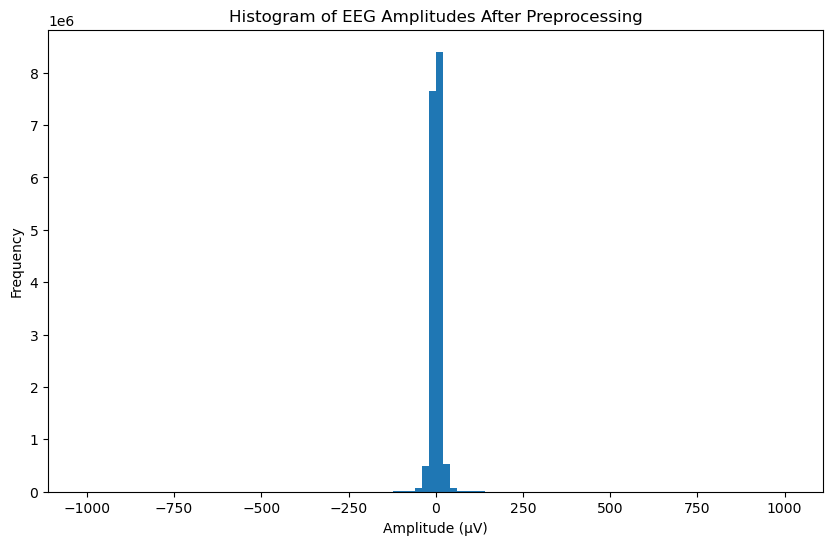

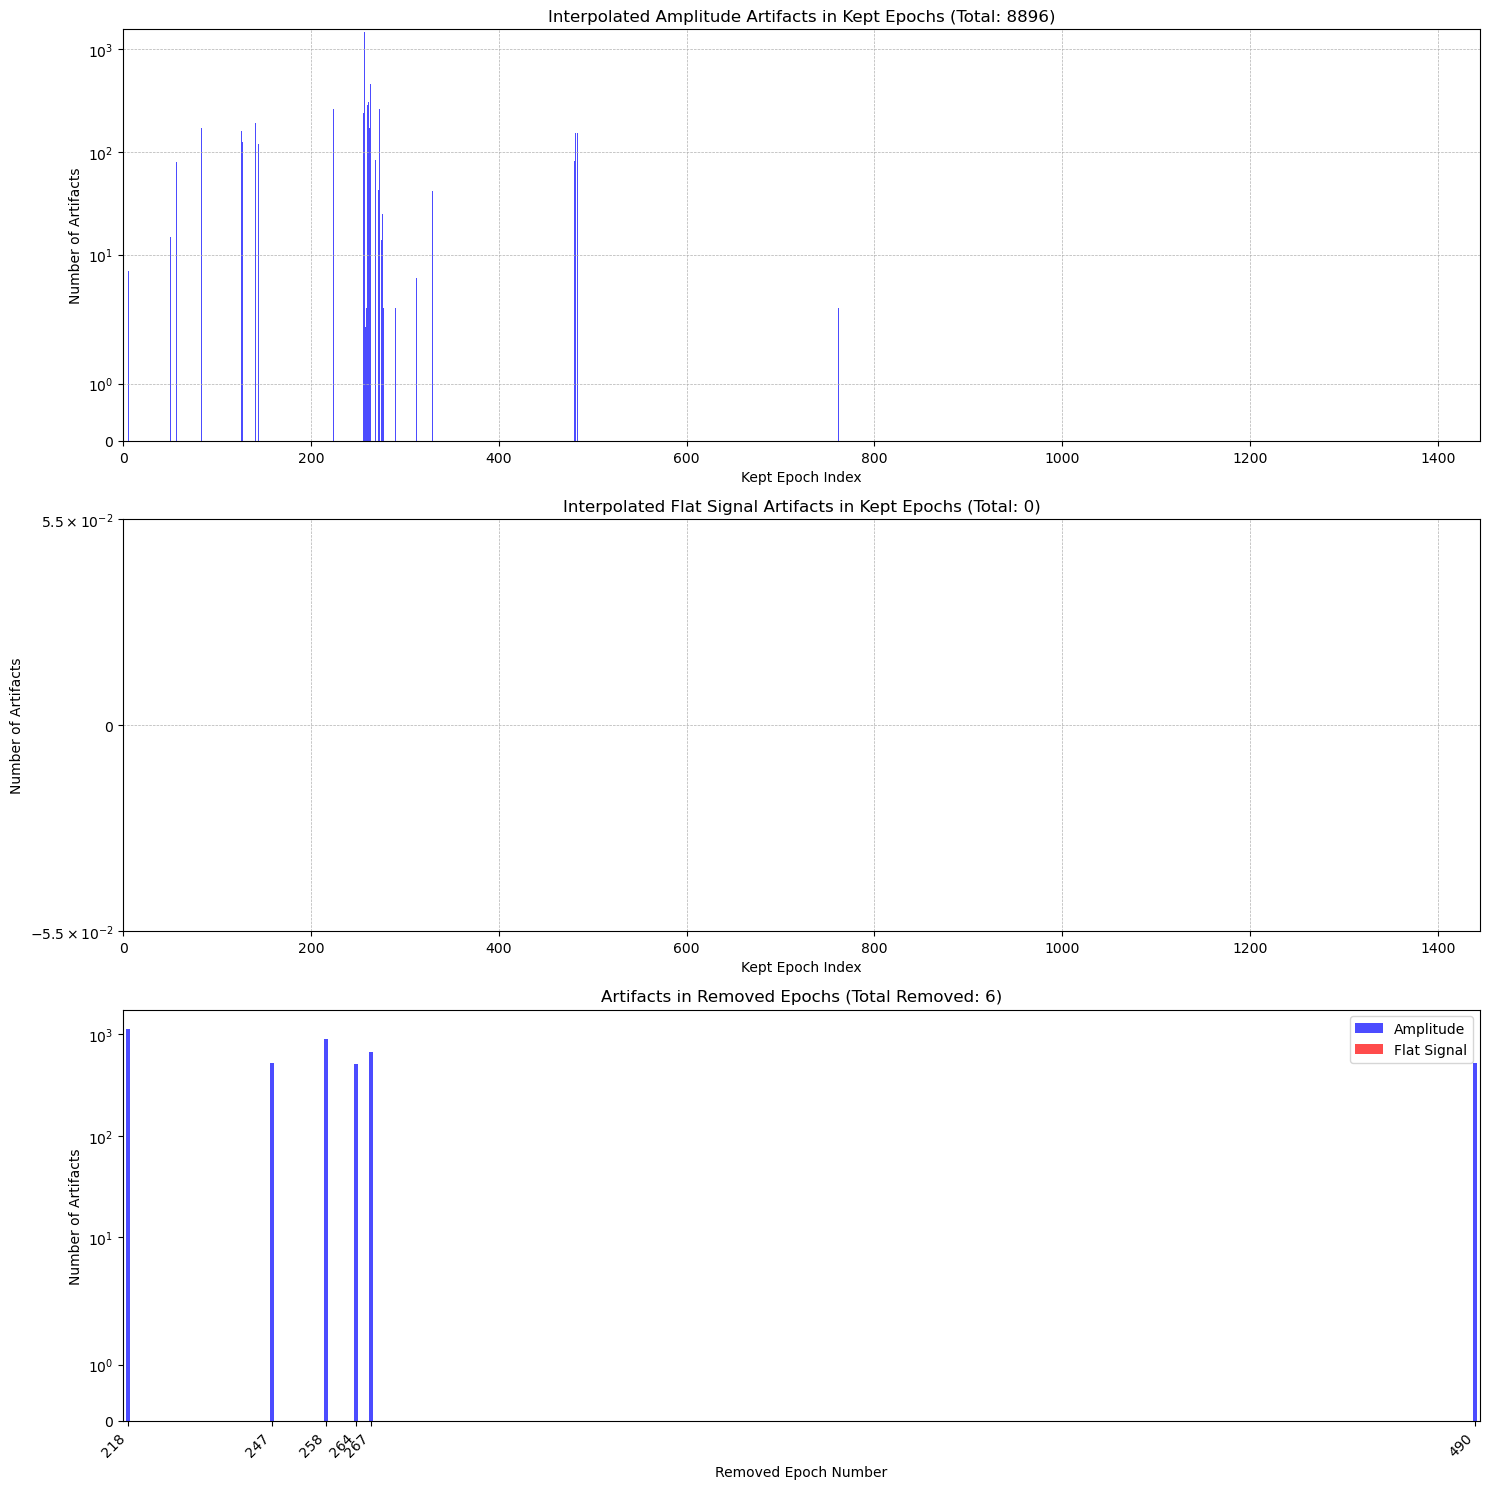

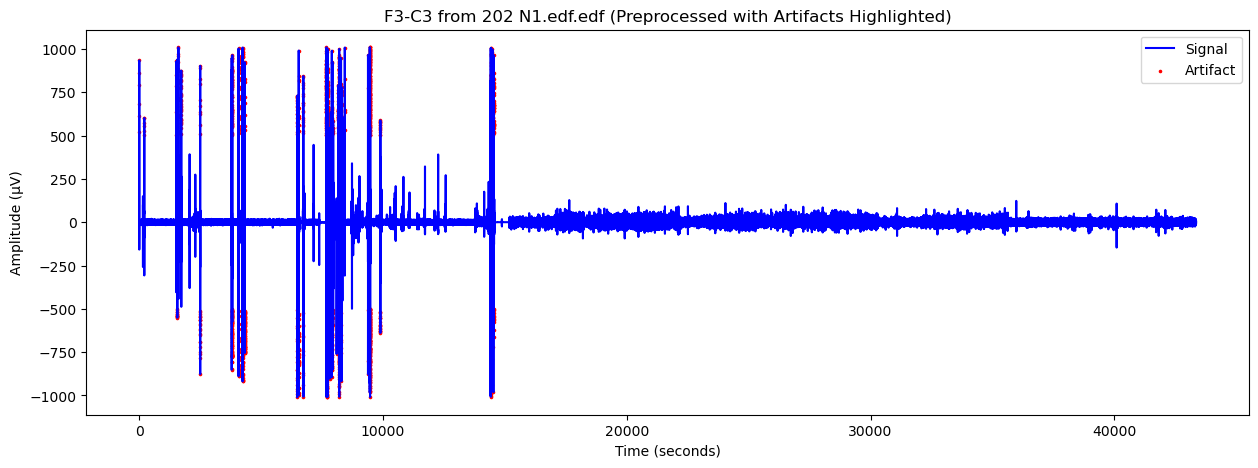

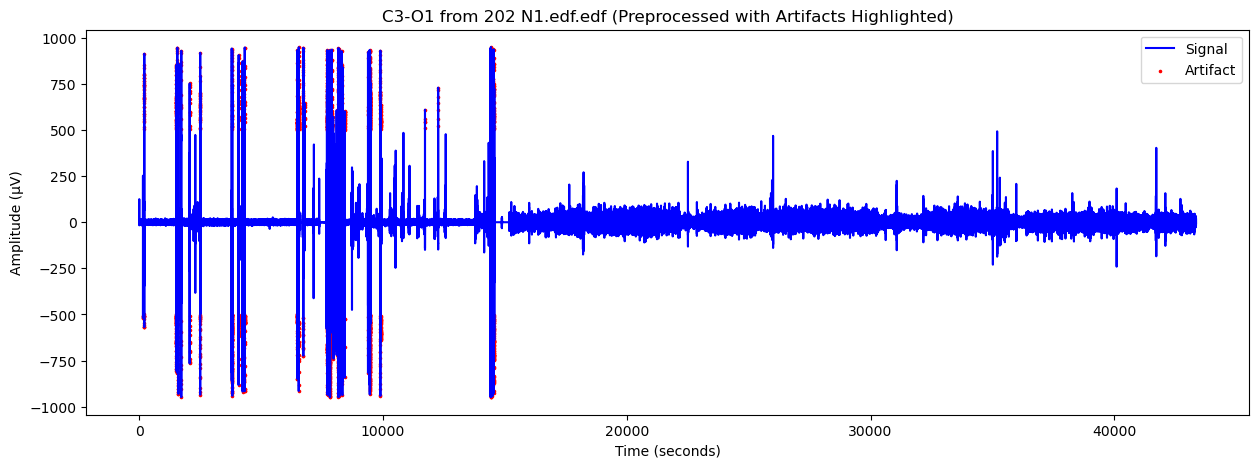

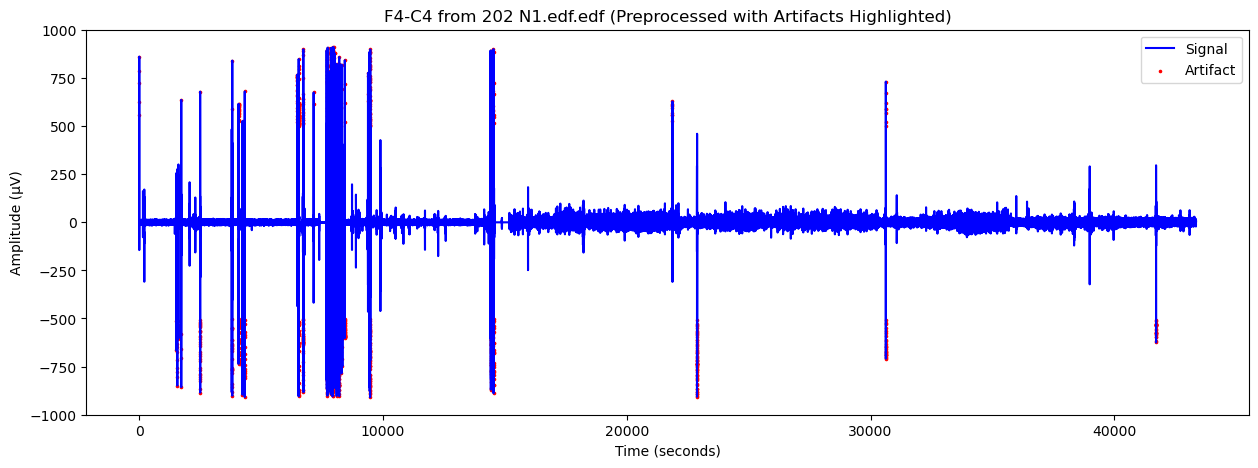

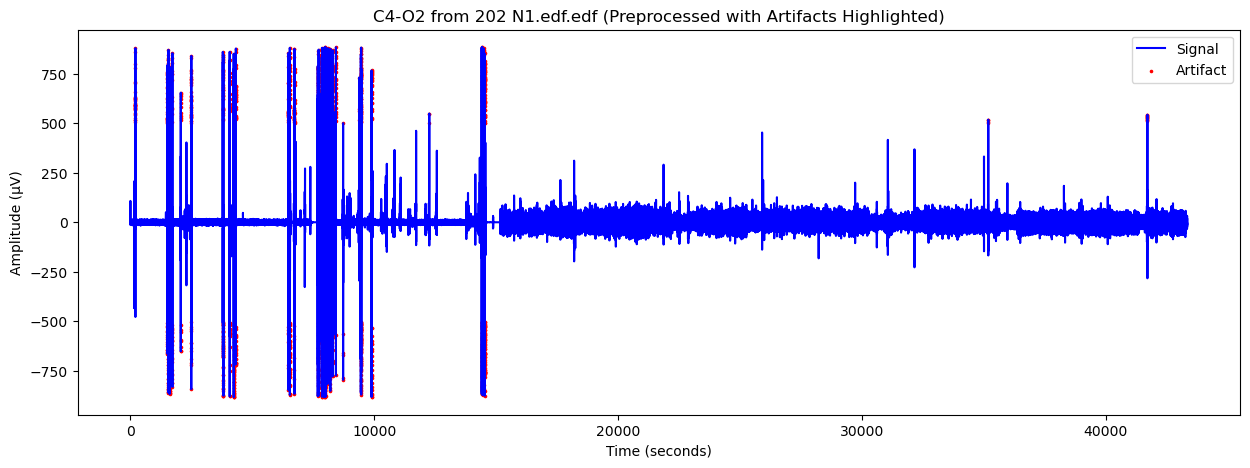

Final data range: -1009.98 to 1009.60 μV
Number of sleep stages: 1445
Number of epochs: 1445


In [2]:
# Load EEG data and sleep stages
raw = load_edf_file(EDF_PATH)
raw = preprocess_eeg(raw)
epochs = create_epochs(raw)



# Initialize arrays to track artifacts
num_epochs = epochs._data.shape[0]
amplitude_artifact_counts = np.zeros(num_epochs)
flat_artifact_counts = np.zeros(num_epochs)
epochs_to_remove = []


# Inspect EEG epochs and sleep stages length before any masking or indexing
print(f"EEG data epochs shape: {epochs._data.shape}")  # Expecting [1175, 4, 3000] or similar
sleep_stages = preprocess_sleep_stages(SLEEP_STAGES_PATH, epochs_to_remove, keep_unscored=True)
print(f"Sleep stages shape: {sleep_stages.shape}")  # Expecting [1175] or similar

# Ensure shapes are compatible before masking
if epochs._data.shape[0] != sleep_stages.shape[1]:
    logging.error(f"Mismatch found: EEG data has {epochs._data.shape[0]} epochs, but sleep stages has {sleep_stages.shape[1]}")
else:
    print("Shapes are compatible for masking operation.")

# Apply artifact detection and handling
for i in range(num_epochs):
    for j in range(epochs._data.shape[1]):
        data_epoch = epochs._data[i, j, :]
        amplitude_mask, flat_mask = detect_artifacts(data_epoch, sfreq=raw.info['sfreq'])
        artifact_mask = amplitude_mask | flat_mask
        
        amplitude_artifact_counts[i] += np.sum(amplitude_mask)
        flat_artifact_counts[i] += np.sum(flat_mask)
        
        if (np.sum(amplitude_mask) >= 5 * raw.info['sfreq']) or (np.sum(flat_mask) >= 5 * raw.info['sfreq']):
            epochs_to_remove.append(i)
            break
        
        epochs._data[i, j, :] = handle_artifacts(data_epoch, artifact_mask)

# Separate artifact counts for kept and removed epochs
kept_amplitude_counts = np.delete(amplitude_artifact_counts, epochs_to_remove)
kept_flat_counts = np.delete(flat_artifact_counts, epochs_to_remove)
removed_amplitude_counts = amplitude_artifact_counts[epochs_to_remove]
removed_flat_counts = flat_artifact_counts[epochs_to_remove]

# Remove epochs marked for removal
epochs.drop(epochs_to_remove)

# Scale each channel
for i, ch in enumerate(raw.ch_names):
    data = epochs.get_data(picks=ch).reshape(-1)
    scaled_data = scale_channel_data(data, IQR_TARGET[i].item(), MED_TARGET[i].item())
    epochs._data[:, epochs.ch_names.index(ch), :] = scaled_data.reshape(epochs._data.shape[0], -1)

# Extract preprocessed data
preprocessed_data = epochs.get_data()

# Prepare and save data
mat_dict = {
    'sig1': preprocessed_data[:, 0, :],
    'sig2': preprocessed_data[:, 1, :],
    'sig3': preprocessed_data[:, 2, :],
    'sig4': preprocessed_data[:, 3, :],
    'Fs': raw.info['sfreq'],
    'ch_names': raw.ch_names,
    'labels': preprocess_sleep_stages(SLEEP_STAGES_PATH, epochs_to_remove, keep_unscored=True)
}

try:
    savemat(PREPROCESSED_FILE_NAME, mat_dict)
    print("Data saved successfully.")
except Exception as e:
    print(f"Error saving data: {e}")

# Print summary
print(f"Total interpolated amplitude artifacts in kept epochs: {int(np.sum(kept_amplitude_counts))}")
print(f"Total interpolated flat signal artifacts in kept epochs: {int(np.sum(kept_flat_counts))}")
print(f"Total amplitude artifacts in removed epochs: {int(np.sum(removed_amplitude_counts))}")
print(f"Total flat signal artifacts in removed epochs: {int(np.sum(removed_flat_counts))}")
print(f"Number of epochs removed due to long artifacts: {len(epochs_to_remove)}")
print(f"Final data range: {preprocessed_data.min():.2f} to {preprocessed_data.max():.2f} μV")

# Plot results
plot_histogram(preprocessed_data, title='Histogram of EEG Amplitudes After Preprocessing')
plot_artifact_summary(kept_amplitude_counts, kept_flat_counts, removed_amplitude_counts, removed_flat_counts, epochs_to_remove)

# Plot each channel and highlight artifacts
for i, ch_name in enumerate(raw.ch_names):
    channel_data = preprocessed_data[:, i, :].flatten()
    amplitude_mask, flat_mask = detect_artifacts(channel_data, sfreq=raw.info['sfreq'])
    plot_channel(channel_data, amplitude_mask | flat_mask, ch_name, raw.info['sfreq'])

# Check data quality
check_data_quality(preprocessed_data)

# Print number of sleep stages and epochs
print(f"Number of sleep stages: {mat_dict['labels'].shape[1]}")
print(f"Number of epochs: {preprocessed_data.shape[0]}")

Preprocessed data loaded successfully.
Total Length of time in hours: 8.19
EEG and sleep stages plot saved as 'eeg_and_sleep_stages.png'
Number of sleep stages: 983
Number of epochs: 983


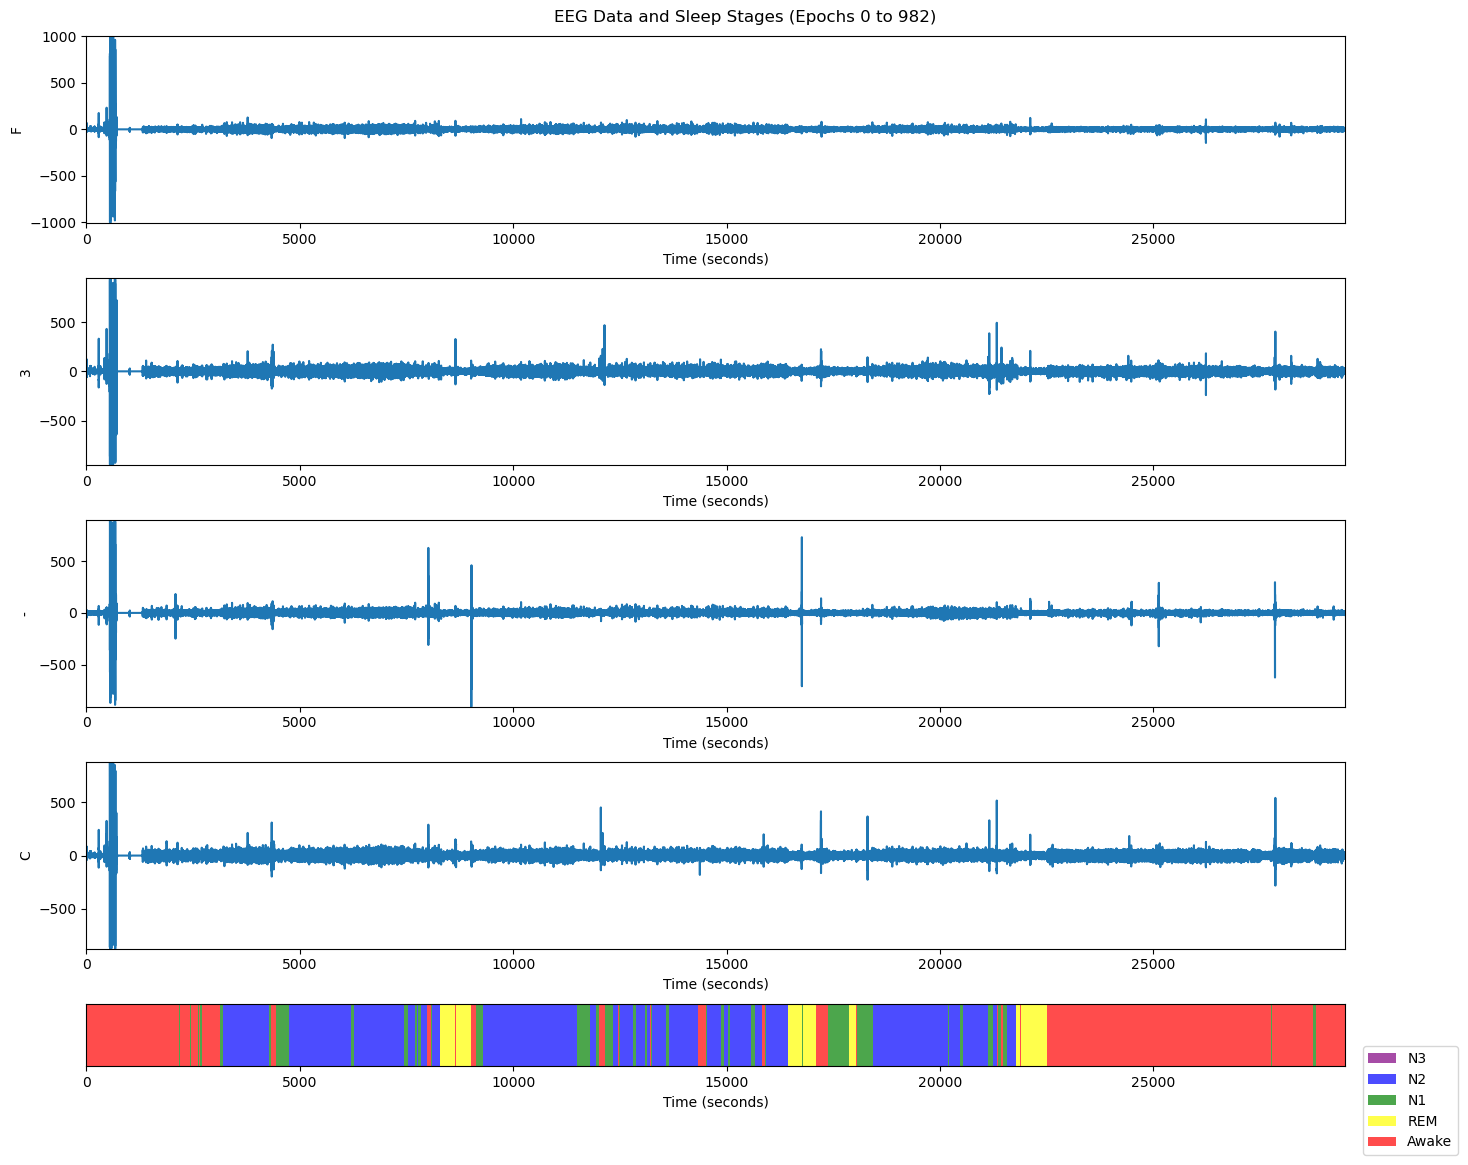

In [3]:
try:
    x, y, fs, ch_names = load_preprocessed_data(PREPROCESSED_FILE_NAME)
    print("Preprocessed data loaded successfully.")
except Exception as e:
    print(f"Error loading preprocessed data: {e}")
    

# Plot EEG data and sleep stages
fig_eeg_stages = plot_eeg_and_sleep_stages(x, y, fs, ch_names)

fig_eeg_stages.savefig('eeg_and_sleep_stages.png')

print("EEG and sleep stages plot saved as 'eeg_and_sleep_stages.png'")

# Print number of sleep stages and epochs
print(f"Number of sleep stages: {y.shape[0]}")
print(f"Number of epochs: {x.shape[0]}")

# Show the plot
plt.show()
plt.close(fig_eeg_stages)
